In [1]:
import cv2
import sys 
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import isfile, join
import random
from skimage.feature import local_binary_pattern

folder_path = '../atividade_final/dat'

In [2]:
def item_freq(a):
    items, freq = np.unique(a, return_counts=True)
    return np.array([items, freq]).T

class ImageItem:
    def __init__(self, image_name, image_path, image_class):
        self.image_name = image_name
        self.image_path = image_path
        self.image_class = image_class  
        
    def read_image(self):
        return cv2.imread(self.image_path, cv2.IMREAD_GRAYSCALE)
    
    def __str__(self):
        return "class: '%s', path: '%s'" % (self.image_class, self.image_path)

class ImageItemCollection:
    def __init__(self):
        self.array = []
        self.by_class = {}
        
    def append(self, image_item):
        self.array.append(image_item)
        if not (image_item.image_class in self.by_class):
            self.by_class[image_item.image_class] = []
        self.by_class[image_item.image_class].append(image_item)
        
    def build_training_and_validation_sets(self, training_pct = 0.7):
        training_set = []
        validation_set = []
        for class_key in self.by_class:
            class_items = items.by_class[class_key]
            training_ammount = int(len(class_items) * training_pct)

            #shuffle without changing image_collection following functional principles
            shuffle_result = sorted(class_items, key=lambda class_items: random.random())

            for i in range(0,len(shuffle_result)):
                if i < training_ammount:
                    training_set.append(shuffle_result[i])
                else:
                    validation_set.append(shuffle_result[i])
        return (training_set, validation_set)
    
class EpDefaultReader:
    @staticmethod
    def list_files(folder_path):
        folder_items = os.listdir(folder_path)
        folder_files = [f for f in folder_items if isfile(join(folder_path, f))]
        return folder_files
    @staticmethod
    def get_image_class(folder_file):
        return folder_file.split("_")[0]
    @staticmethod
    def load_items(folder_path):
        folder_files = EpDefaultReader.list_files(folder_path)
        if len(folder_files) <= 0:
            raise ValueError("Folder should contain at least one file")
        items = ImageItemCollection()
        for folder_file in folder_files:
            full_path = join(folder_path, folder_file)
            image_class = EpDefaultReader.get_image_class(folder_file)
            items.append(ImageItem(folder_file, full_path, image_class))
        return items


class LbpResult:
    def __init__(self, image, image_class, lbp):
        self.image = image
        self.image_class = image_class
        self.lbp = lbp
        orig_histogram = item_freq(lbp.ravel())
        self.histogram = orig_histogram[:, 1]/sum(orig_histogram[:, 1])
        
    def plot(self):
        x = np.arange(0, len(self.histogram))

        fig, ax = plt.subplots(1,3, figsize=(15,5))
        ax[0].imshow(self.image, cmap='gray')
        ax[0].set_title("Classe: %s" % (self.image_class))
        ax[1].imshow(self.lbp, cmap='gray')
        ax[1].set_title("LBP")
        ax[2].bar(x, self.histogram)
        ax[2].set_ylim([0, 1])
        ax[2].set_title("Histograma Normalizado")
        
        plt.show()

def calculate_lbp(image, image_class, radius = 2):
    no_points = 8 * radius
    # Uniform LBP is used
    lbp = local_binary_pattern(image, no_points, radius, method='uniform')
    return LbpResult(image, image_class, lbp)

def calculate_images_lbp(image_set, radius = 2):
    lbp_results = []
    for item in image_set:
        image = item.read_image()
        lbp_result = calculate_lbp(image, item.image_class, radius = 2)
        lbp_results.append(lbp_result)
    return lbp_results


# OpenCV uses sum of squared distance as compactnes s
def sum_of_squared_distances(point_a, point_b):
    return np.sum((point_a - point_b)**2)

def print_confusion_matrix(original_labels, result_labels, confusion_matrix):
    acc = ""
    acc += "---"*len(confusion_matrix[0])*3+"\n"
    acc += " \t|"
    for item in original_labels:
        acc += item + "\t"
    acc += "\n"
    for i in range(len(confusion_matrix)):
        lin = confusion_matrix[i]
        acc += "---"*len(lin)*3+"\n"
        acc += str(result_labels[i])+"\t|"
        for inlin in lin:
            acc += str(inlin)+"\t"
        acc += "\n"
    acc += "---"*len(lin)*3+"\n"
    print(acc)

    
def classify(current_hist, centers):
    min_i = -1
    min_error = sys.float_info.max
    
    for i in range(len(centers)):
        center = centers[i]
        current_error = sum_of_squared_distances(current_hist, center)
        if min_error > current_error:
            min_i = i
            min_error = current_error
    return min_i

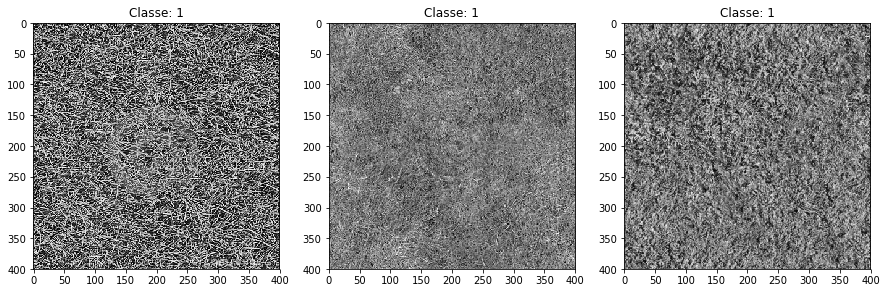

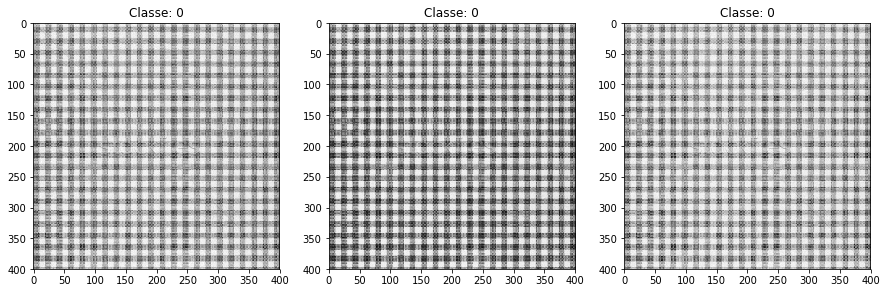

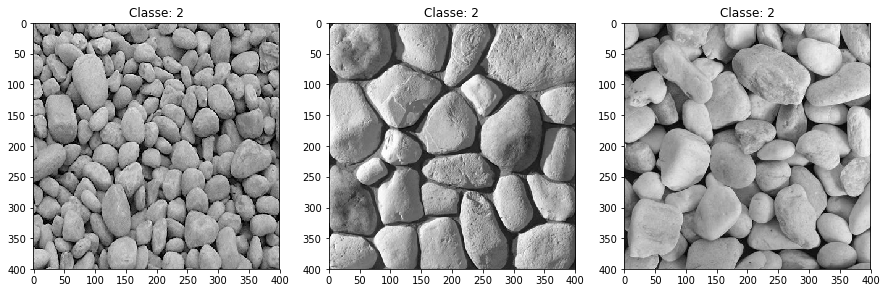

In [3]:
items = EpDefaultReader.load_items(folder_path)

for class_key in items.by_class:
    class_items = items.by_class[class_key]
    fig, imgs = plt.subplots(1,len(class_items), figsize=(15,5))
    for i in range(len(class_items)):
        image = class_items[i].read_image()
        imgs[i].imshow(image, cmap='gray')
        imgs[i].set_title("Classe: %s" % (class_items[i].image_class))
    plt.show()
    

Training


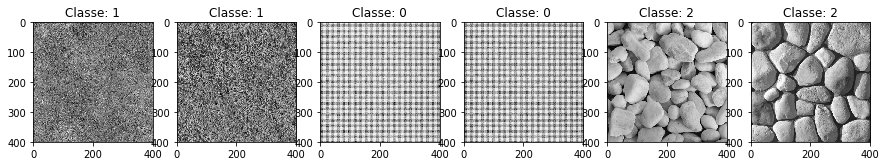

Validation


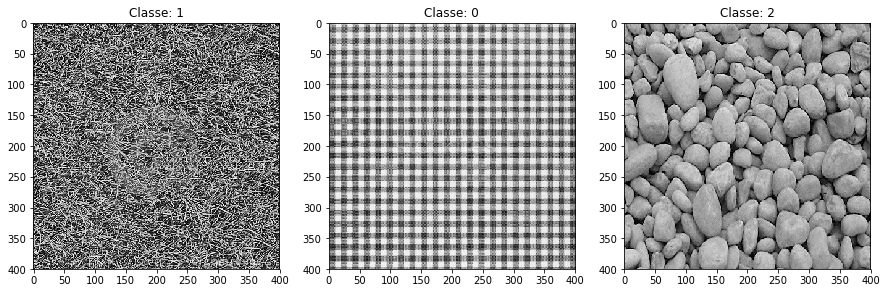

In [4]:
(training_set, validation_set) = items.build_training_and_validation_sets()

print("Training")
fig, imgs = plt.subplots(1,len(training_set), figsize=(15,5))
for i in range(len(training_set)):
    item = training_set[i]
    image = item.read_image()
    imgs[i].imshow(image, cmap='gray')
    imgs[i].set_title("Classe: %s" % (item.image_class))
plt.show()
    
print("Validation")
fig, imgs = plt.subplots(1,len(validation_set), figsize=(15,5))
for i in range(len(validation_set)):
    item = validation_set[i]
    image = item.read_image()
    imgs[i].imshow(image, cmap='gray')
    imgs[i].set_title("Classe: %s" % (item.image_class))
plt.show()


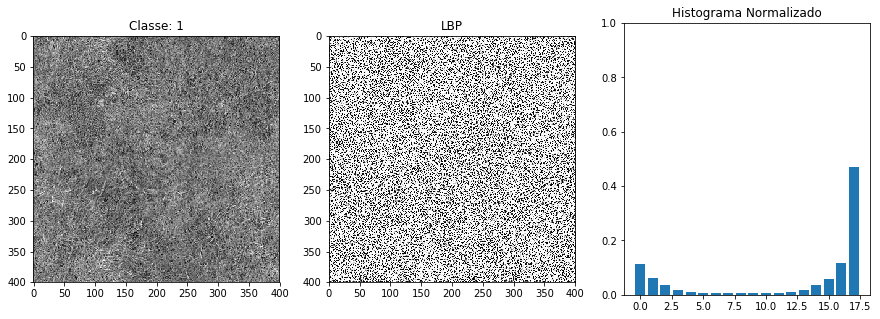

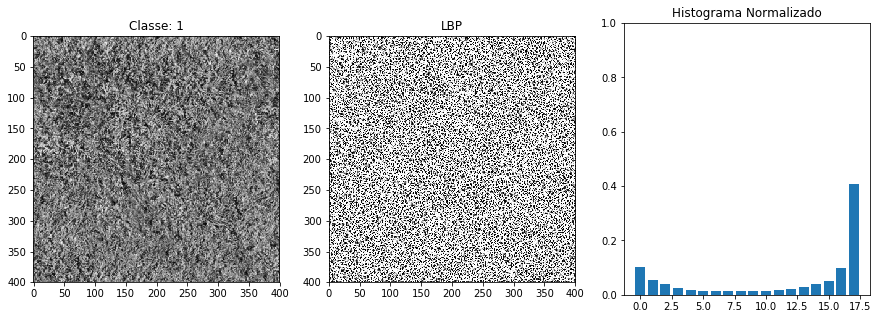

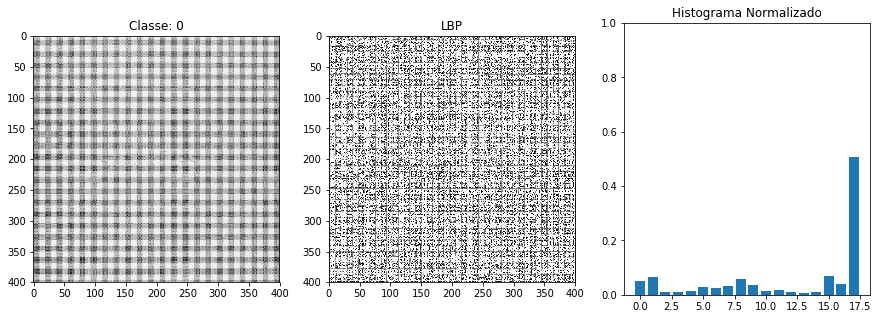

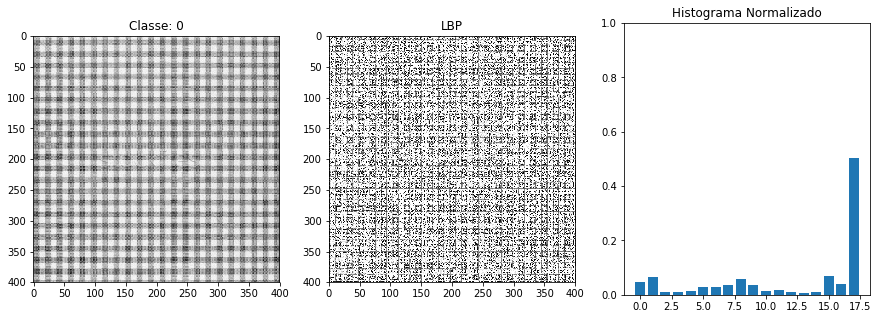

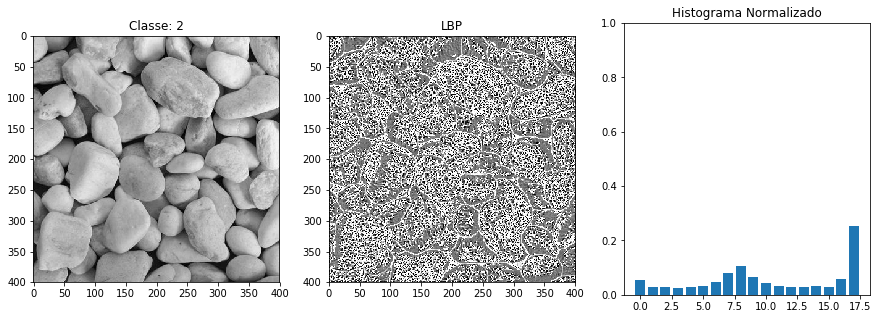

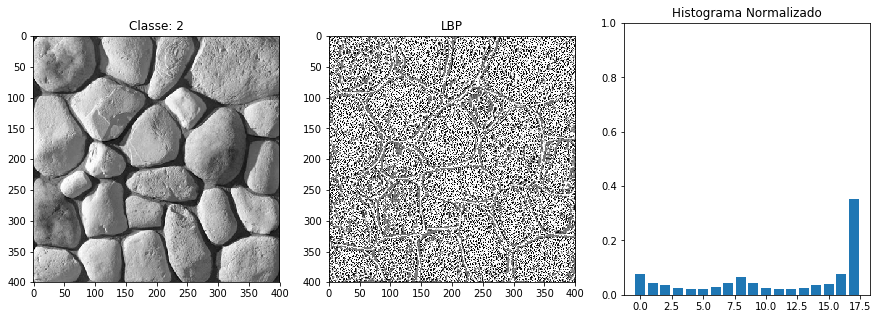

In [5]:
lbp_results = calculate_images_lbp(training_set)
for lbp_result in lbp_results:
    lbp_result.plot()

Labels: [[1 0 1 2 1 2 2 0 0]]
Compacteness: 0.0136625611331
Centers Length: 3
Centers: [[0.06365208 0.03684167 0.03149375 0.02479375 0.02444584 0.02832917
  0.03794375 0.06110834 0.07797292 0.05339792 0.03394791 0.02731458
  0.02405417 0.02751458 0.03389167 0.03544167 0.06563125 0.31222498]
 [0.0471     0.06608542 0.00959167 0.0090625  0.01310625 0.0291375
  0.02827292 0.03585209 0.06040834 0.03695833 0.01381042 0.01671667
  0.00939583 0.00736667 0.01048125 0.06763542 0.03972083 0.49929795]
 [0.11843334 0.0632125  0.03428125 0.01782708 0.0117375  0.00937083
  0.00832708 0.00799167 0.00815625 0.00918958 0.00895417 0.01088125
  0.01378333 0.02085    0.03700417 0.05857917 0.12064792 0.44077295]]



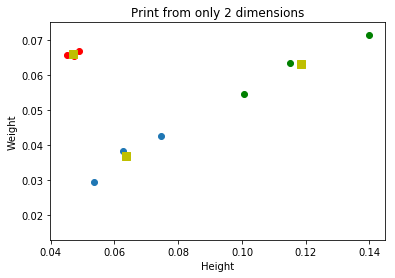

In [16]:
x = []
for lbp in lbp_results:
    x.append(np.float32(lbp.histogram))

k_means_input=np.array(x)
    
k_size = 3
max_iteration = 10
accuracy = 0.3
    
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 
            max_iteration, 
            accuracy)

compactness, labels, centers = cv2.kmeans(k_means_input,
                                          k_size,
                                          None,
                                          criteria,
                                          10,
                                          cv2.KMEANS_RANDOM_CENTERS)

print "Labels: %s"% str(labels.T)
print "Compacteness: %s"% str(compactness)
print "Centers Length: %s"% str(len(centers)) 
print "Centers: %s"% str(centers) 


print 
# Now separate the data, Note the flatten()
A = k_means_input[labels.ravel()==0]
B = k_means_input[labels.ravel()==1]
C = k_means_input[labels.ravel()==2]

# Plot the data
plt.scatter(A[:,0],A[:,1])
plt.scatter(B[:,0],B[:,1],c = 'r')
plt.scatter(C[:,0],C[:,1],c = 'g')
plt.scatter(centers[:,0],centers[:,1],s = 80,c = 'y', marker = 's')
plt.xlabel('Height'),plt.ylabel('Weight')
plt.title("Print from only 2 dimensions")
plt.show()



In [7]:
validation_lbp_results = calculate_images_lbp(validation_set)

keys_array = items.by_class.keys()

confusion_matrix = np.zeros((len(keys_array),len(keys_array)))
for validation_lbp in validation_lbp_results:
    current_hist = np.float32(validation_lbp.histogram)
    
    classified_center = classify(current_hist, centers)
    
    index_of_key = keys_array.index(validation_lbp.image_class)
    confusion_matrix[index_of_key, classified_center] += 1
    
result_labels = np.arange(0,3)
print "\nValidation Confusion Matrix"
print_confusion_matrix(keys_array, result_labels, confusion_matrix)
    



Validation Confusion Matrix
---------------------------
 	|1	0	2	
---------------------------
0	|0.0	0.0	1.0	
---------------------------
1	|1.0	0.0	0.0	
---------------------------
2	|0.0	1.0	0.0	
---------------------------



In [8]:
lbp_results = calculate_images_lbp(items.array)

keys_array = items.by_class.keys()

confusion_matrix = np.zeros((len(keys_array),len(keys_array)))
for lbp_result in lbp_results:
    current_hist = np.float32(lbp_result.histogram)
    
    classified_center = classify(current_hist, centers)
    
    index_of_key = keys_array.index(lbp_result.image_class)
    confusion_matrix[index_of_key, classified_center] += 1
    

result_labels = np.arange(0,3)
print "\nAll Confusion Matrix"
print_confusion_matrix(keys_array, result_labels, confusion_matrix)


All Confusion Matrix
---------------------------
 	|1	0	2	
---------------------------
0	|0.0	0.0	3.0	
---------------------------
1	|3.0	0.0	0.0	
---------------------------
2	|0.0	3.0	0.0	
---------------------------

